# MIT-BIH Arrhythmia Dataset

The MIT-BIH Database is a well-known collection of electrocardiogram (ECG) recordings for arrhythmia analysis ([link from Kaggle](https://www.kaggle.com/datasets/mondejar/mitbih-database))

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
# imports
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from arrhythmia import get_paired_files, read_annotation_file, plot_annotation_class_distribution, \
read_signal_file, process_directory, save_beats_to_csv, plot_dataset_distribution, create_balanced_sample, plot_beat, standardize_beats
from utils import prepare_data, add_label_noise, prepare_ssl_data
from models.cnn import CNN1D
from models.encoder import Encoder, TC
from training import train_model, plot_training_history, train_self_supervised, relabel_dataset

In [3]:
files = get_paired_files("../data/arrhythmia/")
print(f"Number of pairs: {len(files)}")
print(f"Example: {files[0]}")

Number of pairs: 48
Example: ('../data/arrhythmia/100.csv', '../data/arrhythmia/100annotations.txt')


## Exploratory Data Analysis

Check one of the annotations files

In [11]:
annotation_file = files[0][1]
df = read_annotation_file(annotation_file)
df

,Time,pos,label
0,0:00.050,18,1
1,0:00.214,77,0
2,0:01.028,370,0
3,0:01.839,662,0
4,0:02.628,946,0
...,...,...,...
2269,30:02.717,648978,0
2270,30:03.422,649232,0
2271,30:04.122,649484,0
2272,30:04.817,649734,0



Class Distribution Summary:
Total beats: 2274
Normal beats (Class 0): 2239 (98.5%)
Abnormal beats (Class 1): 35 (1.5%)


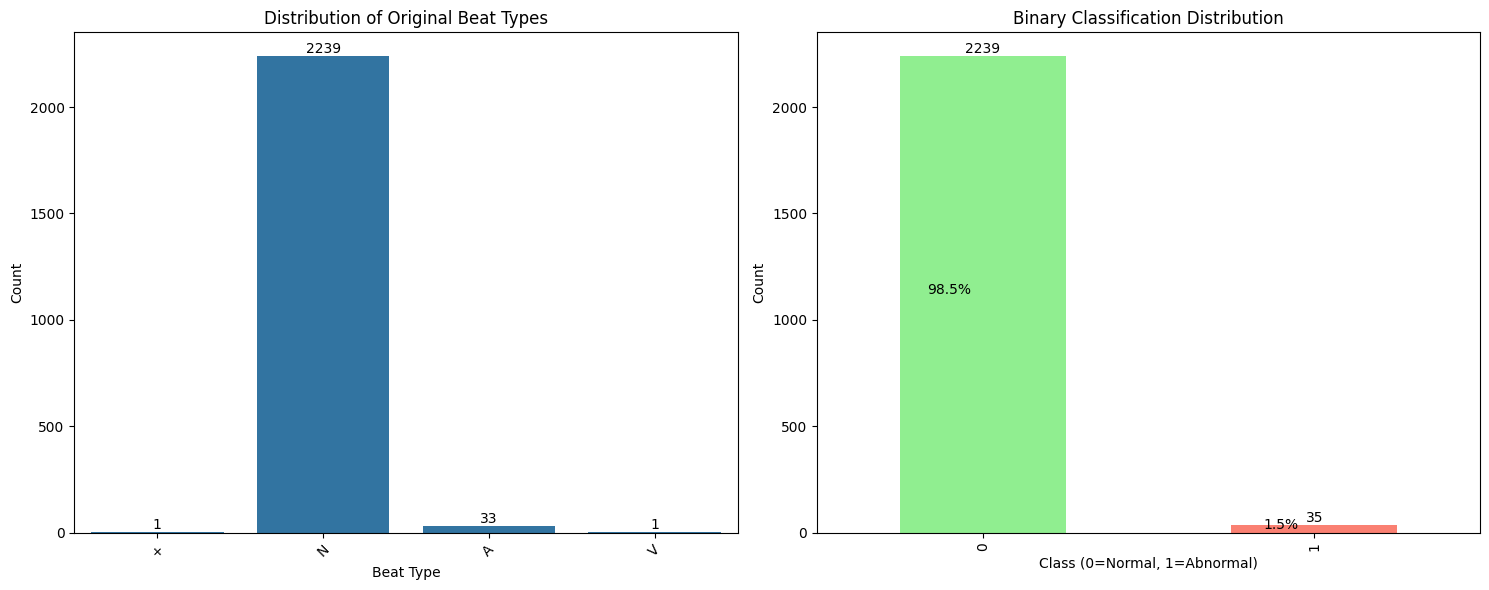

In [42]:
plot_annotation_class_distribution(annotation_file)

Check one of the signal files

In [16]:
signal_file = files[0][0]
data = read_signal_file(signal_file)
data

,pos,signal
0,0,995
1,1,995
2,2,995
3,3,995
4,4,995
...,...,...
649995,649995,1009
649996,649996,935
649997,649997,889
649998,649998,871


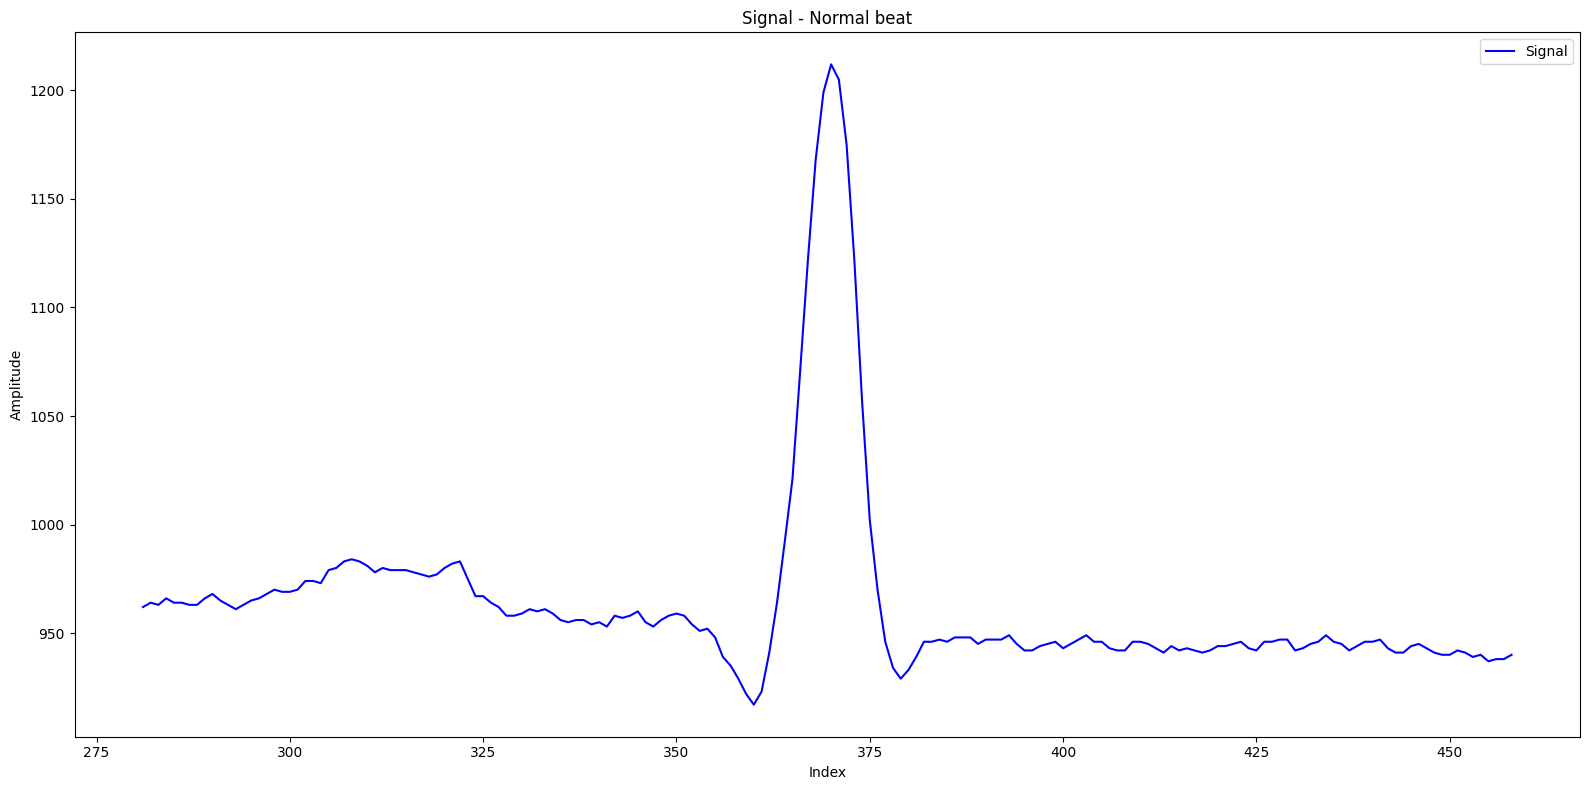

In [20]:
window_size = 89
pos = df['pos'][2]
label = df['label'][2]

label = "Normal beat" if label == 0 else "Arrhythmic beat"

signal = data['signal'][pos-window_size:pos+window_size]
samples = data['pos'][pos-window_size:pos+window_size]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

ax.plot(samples, signal, label='Signal', color='blue')
ax.set_xlabel("Index")
ax.set_ylabel('Amplitude')
ax.set_title('Raw Signal')
ax.legend()
ax.set_title(f'Signal - {label}')

plt.tight_layout()
plt.show()

## Preprocessing

In [29]:
beats = process_directory("../data/arrhythmia/")


Processing: 100
Extracted 2271 beats from 100

Processing: 101
Extracted 1872 beats from 101

Processing: 102
Extracted 2191 beats from 102

Processing: 103
Extracted 2090 beats from 103

Processing: 104
Extracted 2309 beats from 104

Processing: 105
Extracted 2690 beats from 105

Processing: 106
Extracted 2097 beats from 106

Processing: 107
Extracted 2139 beats from 107

Processing: 108
Extracted 1822 beats from 108

Processing: 109
Extracted 2533 beats from 109

Processing: 111
Extracted 2132 beats from 111

Processing: 112
Extracted 2549 beats from 112

Processing: 113
Extracted 1794 beats from 113

Processing: 114
Extracted 1889 beats from 114

Processing: 115
Extracted 1960 beats from 115

Processing: 116
Extracted 2420 beats from 116

Processing: 117
Extracted 1537 beats from 117

Processing: 118
Extracted 2299 beats from 118

Processing: 119
Extracted 2093 beats from 119

Processing: 121
Extracted 1875 beats from 121

Processing: 122
Extracted 2478 beats from 122

Processing: 

In [30]:
save_beats_to_csv(beats, "../data/arrhythmia/extracted_beats.csv")

Saved 112579 beats to ../data/arrhythmia/extracted_beats.csv
CSV shape: (112579, 179)

Class distribution:
label
0    75033
1    37546
Name: count, dtype: int64


In [30]:
dataset = pd.read_csv("../data/arrhythmia/extracted_beats.csv")
dataset

,0,1,2,3,4,5,6,7,8,9,...,169,170,171,172,173,174,175,176,177,label
0,962,964,963,966,964,964,963,963,966,968,...,940,942,941,939,940,937,938,938,940,0
1,955,955,953,954,956,958,956,956,956,958,...,944,941,943,943,942,941,940,940,939,0
2,947,953,952,953,952,952,950,952,955,953,...,951,950,949,947,946,946,949,951,947,0
3,955,954,953,955,958,958,957,957,956,958,...,943,939,939,939,940,939,934,935,934,0
4,956,956,959,959,959,955,954,956,958,960,...,944,945,945,943,942,939,939,942,942,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112574,986,985,982,980,982,981,986,986,986,987,...,983,981,982,981,981,981,979,988,985,0
112575,977,977,978,978,979,982,984,985,983,981,...,957,960,966,967,970,970,969,971,970,0
112576,970,970,971,971,970,974,975,974,974,973,...,971,969,971,970,972,973,973,972,971,0
112577,979,983,982,981,978,977,978,977,979,976,...,984,985,984,981,981,982,984,981,979,0



Label Distribution Summary:
Total beats: 112579
Label 0: 75033 beats (66.65%)
Label 1: 37546 beats (33.35%)


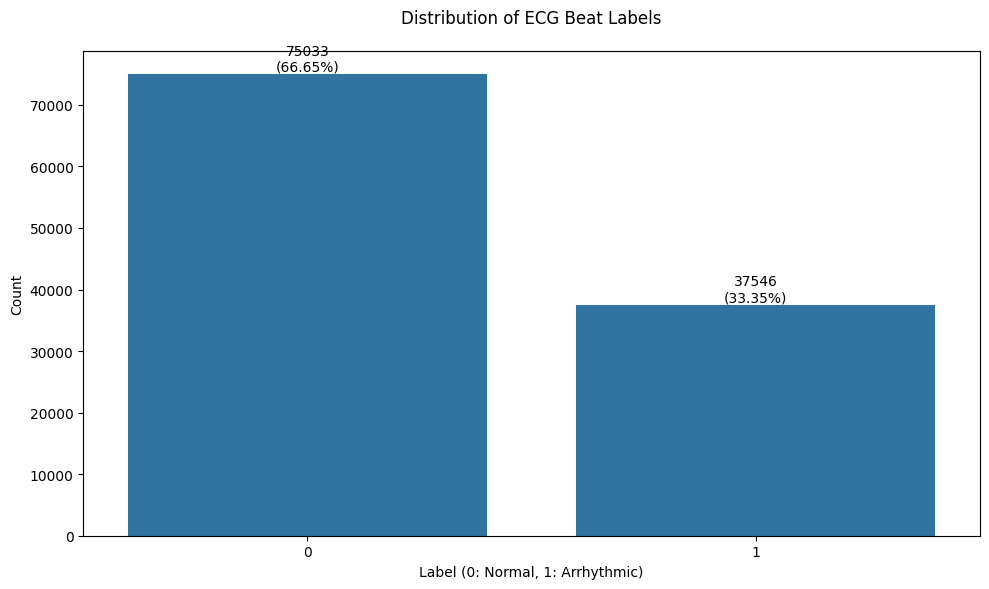

In [31]:
plot_dataset_distribution(dataset)

We can see that the dataset is unbalanced we need to balance the dataset

In [32]:
dataset = create_balanced_sample(dataset)

Original distribution:
Normal beats: 75033
Arrhythmic beats: 37546

New distribution:
label
1    10000
0    10000
Name: count, dtype: int64



Label Distribution Summary:
Total beats: 20000
Label 0: 10000 beats (50.0%)
Label 1: 10000 beats (50.0%)


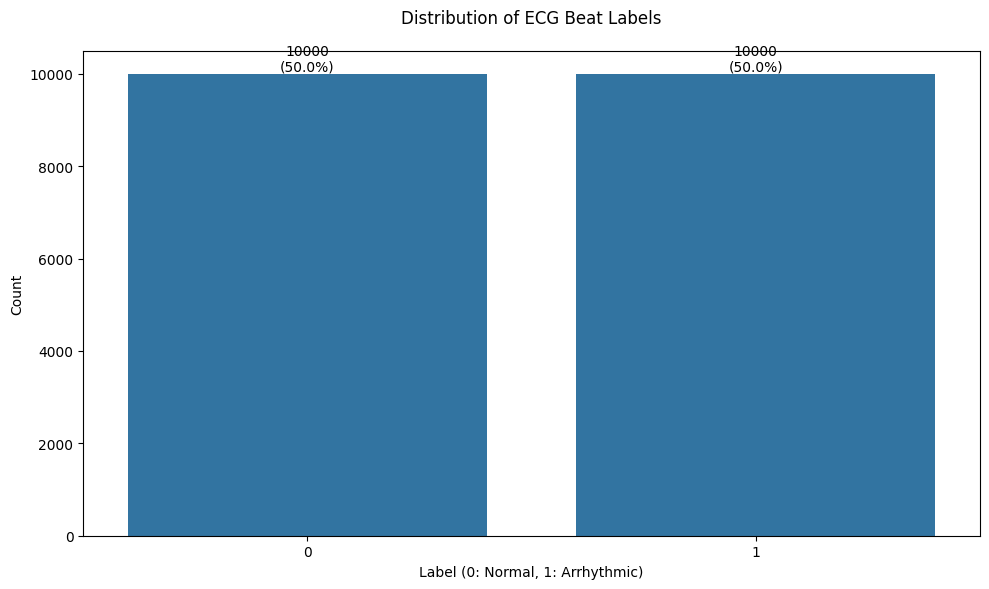

In [33]:
plot_dataset_distribution(dataset)

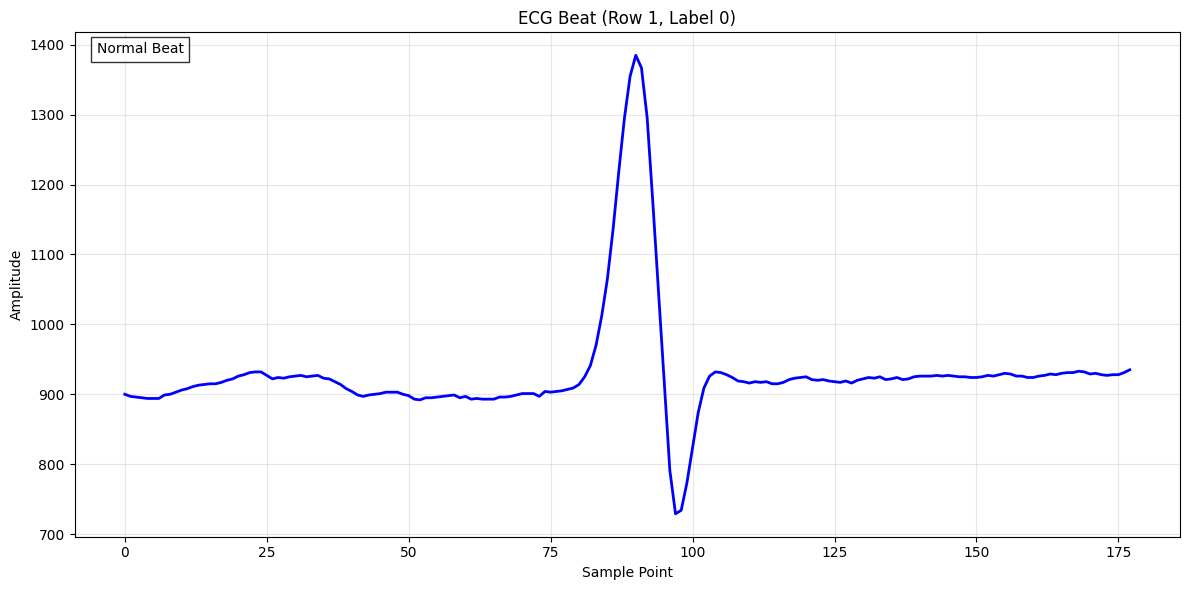

In [34]:
plot_beat(dataset, 1)

Standarize the dataset

In [35]:
dataset = standardize_beats(dataset)

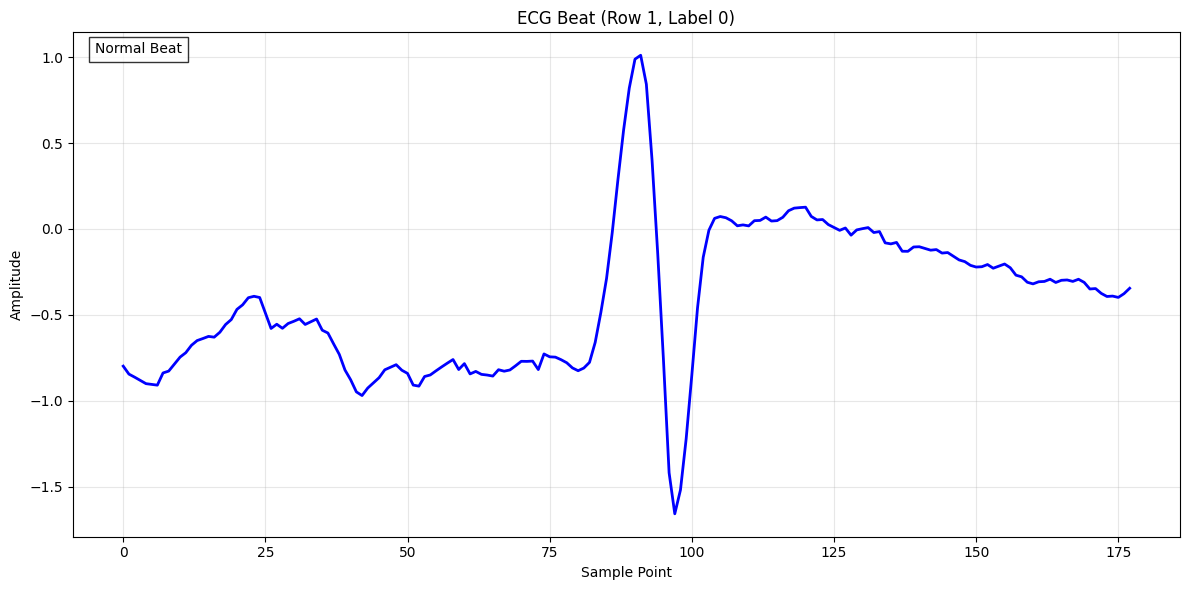

In [36]:
plot_beat(dataset, 1)

# Supervised learning using our custom 1D CNN

In [64]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
# Prepare data loaders
train_loader, val_loader = prepare_data(dataset, batch_size=BATCH_SIZE, train_split=0.8)

In [67]:
# Initialize model
model = CNN1D(input_size=178, num_classes=2)

In [68]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [69]:
# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                     num_epochs=NUM_EPOCHS, device=DEVICE)

Training Progress: 100%|█| 100/100 [01:16<00:00,  1.31it/s, train_loss=0.0018, train_acc=0.9995, train_f1=0.9995, val_loss=0.0882, val_acc=0.9838, val


Training completed! Best model saved at epoch 73
Best validation Accuracy: 0.9870
Best validation F1-score: 0.9872


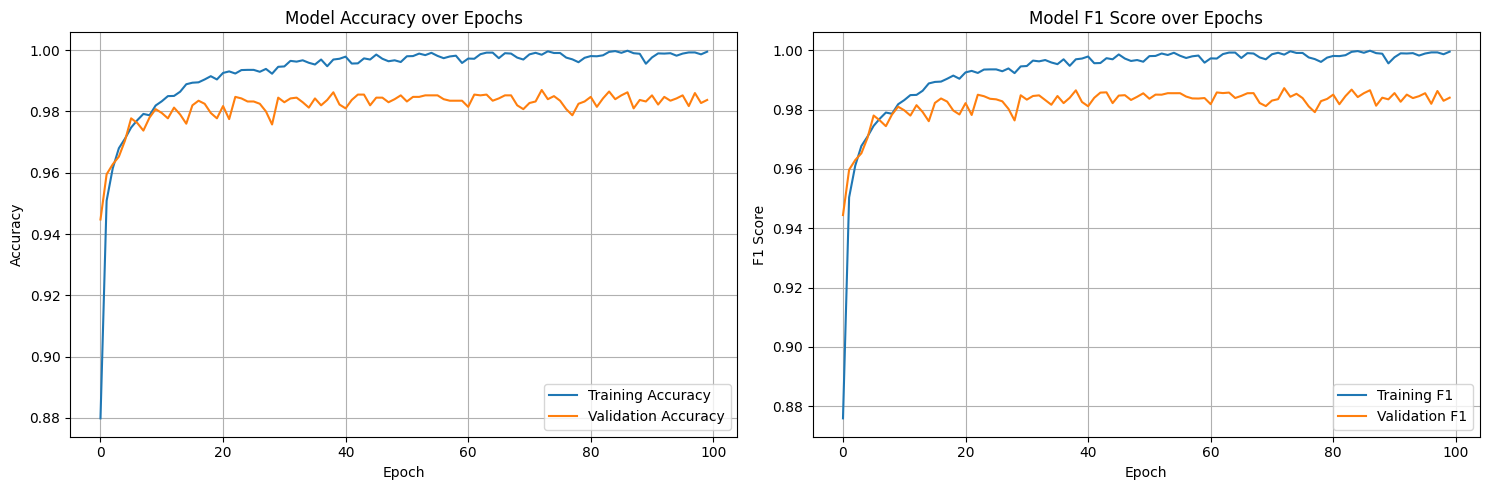

In [70]:
plot_training_history(history)


Training with 0% noise:
Requested noise ratio: 0.00%
Actual noise ratio: 0.00%
Number of flipped labels: 0

Class distribution:
Original:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [02:22<00:00,  2.86s/it, train_loss=0.0064, train_acc=0.9978, train_f1=0.9977, val_loss=0.0805, val_acc=0.9835, val_f



Training completed! Best model saved at epoch 19
Best validation Accuracy: 0.9882
Best validation F1-score: 0.9885

Training with 10.0% noise:
Requested noise ratio: 10.00%
Actual noise ratio: 10.00%
Number of flipped labels: 2000

Class distribution:
Original:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5006
0    0.4994
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [02:24<00:00,  2.89s/it, train_loss=0.1553, train_acc=0.9397, train_f1=0.9395, val_loss=0.7244, val_acc=0.8485, val_f



Training completed! Best model saved at epoch 18
Best validation Accuracy: 0.8838
Best validation F1-score: 0.8867

Training with 20.0% noise:
Requested noise ratio: 20.00%
Actual noise ratio: 20.00%
Number of flipped labels: 4000

Class distribution:
Original:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5055
0    0.4945
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [02:22<00:00,  2.84s/it, train_loss=0.3482, train_acc=0.8427, train_f1=0.8400, val_loss=0.7584, val_acc=0.7228, val_f



Training completed! Best model saved at epoch 15
Best validation Accuracy: 0.7775
Best validation F1-score: 0.7849

Training with 30.0% noise:
Requested noise ratio: 30.00%
Actual noise ratio: 30.00%
Number of flipped labels: 6000

Class distribution:
Original:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.506
0    0.494
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [02:28<00:00,  2.97s/it, train_loss=0.4474, train_acc=0.7717, train_f1=0.7839, val_loss=0.8829, val_acc=0.6432, val_f



Training completed! Best model saved at epoch 16
Best validation Accuracy: 0.6797
Best validation F1-score: 0.6936

Training with 40.0% noise:
Requested noise ratio: 40.00%
Actual noise ratio: 40.00%
Number of flipped labels: 8000

Class distribution:
Original:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5082
0    0.4918
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [02:22<00:00,  2.86s/it, train_loss=0.6181, train_acc=0.6596, train_f1=0.6477, val_loss=0.7311, val_acc=0.5540, val_f



Training completed! Best model saved at epoch 8
Best validation Accuracy: 0.5810
Best validation F1-score: 0.6203

Training with 50.0% noise:
Requested noise ratio: 50.00%
Actual noise ratio: 50.00%
Number of flipped labels: 10000

Class distribution:
Original:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5048
0    0.4952
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [02:24<00:00,  2.88s/it, train_loss=0.6932, train_acc=0.5022, train_f1=0.5713, val_loss=0.6930, val_acc=0.5120, val_f



Training completed! Best model saved at epoch 2
Best validation Accuracy: 0.5120
Best validation F1-score: 0.6772


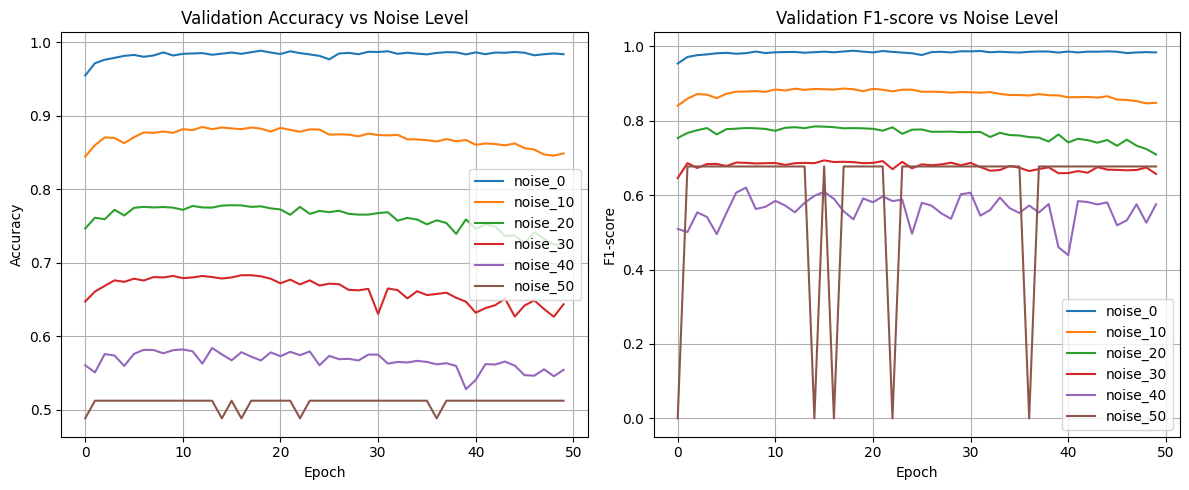

In [29]:
# Create datasets with different noise levels
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]  # Example: 10%, 20%, 30% noise
results = {}

for noise_level in noise_levels:
    print(f"\nTraining with {noise_level*100}% noise:")
    
    # Add noise to labels
    noisy_data = add_label_noise(dataset, noise_ratio=noise_level)
    
    # Prepare data
    train_loader, val_loader = prepare_data(noisy_data)
    
    # Train model
    model = CNN1D(input_size=noisy_data.shape[1]-1, num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    history = train_model(model, train_loader, val_loader, criterion, optimizer)
    
    # Store results
    results[f"noise_{int(noise_level*100)}"] = history

# Plot results for different noise levels
plt.figure(figsize=(12, 5))

# Plot validation accuracy for different noise levels
plt.subplot(1, 2, 1)
for noise_level in results:
    plt.plot(results[noise_level]['val_acc'], label=f'{noise_level}')
plt.title('Validation Accuracy vs Noise Level')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot validation F1 for different noise levels
plt.subplot(1, 2, 2)
for noise_level in results:
    plt.plot(results[noise_level]['val_f1'], label=f'{noise_level}')
plt.title('Validation F1-score vs Noise Level')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Self Supervised Learning

In [40]:
# Config class for hyperparameters
class Config:
    def __init__(self):
        # Model configs
        self.input_channels = 1
        self.kernel_size = 8
        self.stride = 1
        self.final_out_channels = 128
        self.features_len = 24
        self.num_classes = 2
        self.dropout = 0.35
        
        # Training configs
        self.batch_size = 128
        self.num_epochs = 20
        self.learning_rate = 3e-4
        
        # Augmentation configs
        self.jitter_scale_ratio = 0.001
        self.jitter_ratio = 0.001
        self.max_seg = 12

        # TC (Temporal Contrasting) configs
        self.TC_hidden_dim = 100
        self.TC_timesteps = 10

        # Context Contrastive configs
        self.temperature = 0.2
        self.use_cosine_similarity = True

In [41]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize config
config = Config()

# Prepare data loaders
dataset = add_label_noise(dataset, noise_ratio=0.2) # we created a 20% label noise dataset
train_loader, val_loader, test_loader = prepare_ssl_data(dataset, config)

# Initialize model
encoder = Encoder(config).to(device)
temporal_contr_model = TC(config, device).to(device)

# Train model
encoder = train_self_supervised(encoder, temporal_contr_model, train_loader, config, device)

Requested noise ratio: 20.00%
Actual noise ratio: 20.00%
Number of flipped labels: 4000

Class distribution:
Original:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
label
1    0.5055
0    0.4945
Name: proportion, dtype: float64


C:\projects\ts-ssl-label-noise\.venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/20], Loss: 11.5830
Epoch [2/20], Loss: 10.9514
Epoch [3/20], Loss: 10.6712
Epoch [4/20], Loss: 10.3131
Epoch [5/20], Loss: 10.0207
Epoch [6/20], Loss: 9.6762
Epoch [7/20], Loss: 9.4146
Epoch [8/20], Loss: 9.2858
Epoch [9/20], Loss: 9.2700
Epoch [10/20], Loss: 9.0327
Epoch [11/20], Loss: 8.9400
Epoch [12/20], Loss: 8.8852
Epoch [13/20], Loss: 8.7302
Epoch [14/20], Loss: 8.6892
Epoch [15/20], Loss: 8.4181
Epoch [16/20], Loss: 8.4502
Epoch [17/20], Loss: 8.3333
Epoch [18/20], Loss: 8.1880
Epoch [19/20], Loss: 8.2665
Epoch [20/20], Loss: 8.2354


# Relabeling

In [42]:
relabeled_dataset = relabel_dataset(encoder, dataset, config, device)
relabeled_dataset

,0,1,2,3,4,5,6,7,8,9,...,169,170,171,172,173,174,175,176,177,label
0,-2.508021,-2.501397,-2.526444,-2.567069,-2.564623,-2.606491,-2.603922,-2.617464,-2.630709,-2.630821,...,-2.529753,-2.557288,-2.564829,-2.583470,-2.593574,-2.594194,-2.626452,-2.611176,-2.597913,0
1,-0.798728,-0.845062,-0.862869,-0.881502,-0.900739,-0.904775,-0.909420,-0.838440,-0.827585,-0.787091,...,-0.311258,-0.349683,-0.347207,-0.375268,-0.393270,-0.391039,-0.398734,-0.376995,-0.345415,0
2,0.512713,0.574654,0.607614,0.595233,0.598256,0.631288,0.633787,0.666888,0.746329,0.810808,...,-0.229470,-0.268297,-0.316828,-0.334935,-0.393270,-0.421082,-0.468662,-0.526605,-0.544751,1
3,-0.120905,-0.120416,-0.105347,-0.046177,-0.076292,-0.091565,-0.092428,-0.078174,-0.048268,-0.018871,...,-0.219247,-0.217430,-0.205441,-0.234104,-0.262658,-0.300910,-0.278857,-0.267281,-0.255714,1
4,0.512713,0.530287,0.577907,0.625066,0.628235,0.601169,0.573269,0.514834,0.517119,0.564977,...,0.496397,0.504874,0.523640,0.552379,0.571246,0.600381,0.600243,0.600459,0.641299,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.868360,2.157045,2.390016,2.564214,2.711838,2.860084,2.842691,2.461117,1.877103,1.317833,...,0.383939,0.413314,0.402127,0.411215,0.490870,0.640438,0.760079,0.869758,0.940303,1
19996,0.188537,0.175359,0.191720,0.222320,0.268477,0.239742,0.179902,0.134701,0.135101,0.242324,...,-1.067795,-1.133027,-1.116792,-1.091169,-1.106610,-1.122086,-1.157956,-1.174917,-1.222494,1
19997,-0.297728,-0.253514,-0.268734,-0.269925,-0.241182,-0.091565,0.013478,0.013058,0.028136,0.073316,...,-0.188576,-0.146217,-0.124432,-0.133273,-0.101906,-0.040537,-0.039102,-0.067800,-0.066345,1
19998,-1.638639,-1.614075,-1.620390,-1.567662,-1.575287,-1.627627,-1.665894,-1.659528,-1.668024,-1.693592,...,-1.885674,-1.885850,-1.937009,-1.928068,-1.960610,-1.983319,-2.037056,-2.062605,-2.099573,0


In [74]:
train_loader, val_loader = prepare_data(relabeled_dataset, batch_size=BATCH_SIZE, train_split=0.8)

In [75]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                     num_epochs=NUM_EPOCHS, device=DEVICE)

Training Progress: 100%|█| 100/100 [01:19<00:00,  1.26it/s, train_loss=0.0031, train_acc=0.9989, train_f1=0.9993, val_loss=0.0765, val_acc=0.9840, val


Training completed! Best model saved at epoch 30
Best validation Accuracy: 0.9900
Best validation F1-score: 0.9936


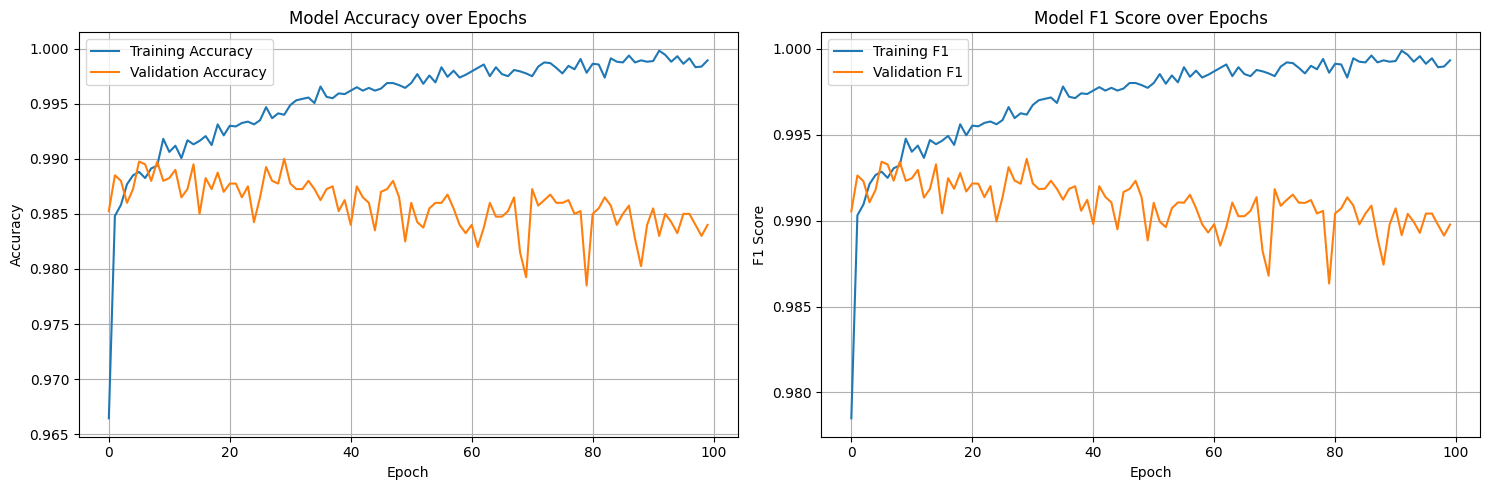

In [76]:
plot_training_history(history)